In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import csv
import struct
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
%config InlineBackend.figure_format = 'svg' 
from datetime import datetime, timedelta

2022-10-28 23:49:48.274957: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# functions

#define moving average function
def moving_avg(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)

def read_roti(filename):
    with open(filename, 'rb') as f:
        header_read = False
        date = None
        lats = []
        rows = []
        date_arr = []
        line = f.readline()
        while not header_read or (line.strip() and not line.strip().startswith(b"END OF ROTIPOLARMAP")):
            if line.strip().startswith(b"START OF ROTIPOLARMAP"):
                header_read = True
            elif line.strip().startswith(b"END OF ROTIPOLARMAP") or line.strip().startswith(b"END OF FILE"):
                break
            elif not header_read:
                pass
            elif line[0:5].strip():
                date = datetime(int(line[0:7]), int(line[7:14]), int(line[14:21]))
                year = int(line[0:7])
                month = int(line[7:14])
                day = int(line[14:21])
                
                date_arr.append(day)
                date_arr.append(month)
                date_arr.append(year)
            else:
                lat, lon_start, lon_end = float(line[3:9]), float(line[9:15]), float(line[15:21])
                lats.append(lat)

                block = [f.readline() for _ in range(18)]
                row = np.genfromtxt(block)
                rows.append(row.ravel())
            line = f.readline()
        return date, np.array(lats), date_arr, np.array(rows)

def plot_data_roti(date, lons, lats, map):
    lons, lats = np.meshgrid(lons, lats)

    fig1 = plt.figure()
    ax = fig1.add_subplot(111, projection='polar')
    levels = np.arange(0, 0.8, 0.1)
    cc = ax.contourf(np.deg2rad(lons), 90. - lats, map, levels=levels, extend='both')

    plt.title("ROTI index date: " + str(date))

    plt.colorbar(cc, ax=ax, label="ROTI, TECU/min")

    mlt = np.linspace(0, 24, 49)

    plt.show()

def plot_data_index(date, array_data, name_index):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    data_month = []
    month_line = []

    data_half_year = []
    half_year_line = []

    data_year = []
    year_line = []

    # ax.set_xlim([date[0][2], date[len(date) - 1][2]])
    # ax.set_ylim([np.min(array_data), np.max(array_data)])
    day_line = np.arange(0, len(date), 1).reshape(len(array_data), 1)

    for i in range(len(array_data)):
        if i % 30 == 0:
            data_month.append(np.mean(array_data[i - 30: i]))
            month_line.append(i - 30 / 2)

    for i in range(len(array_data)):
        if i % 180 == 0:
            data_half_year.append(np.mean(array_data[i - 180: i]))
            half_year_line.append(i - 180 / 2)

    # data_year = moving_avg(array_data, 30)
    for i in range(len(array_data)):
        if i % 365 == 0:
            data_year.append(np.mean(array_data[i - 365: i]))
            year_line.append(i - 365 / 2)

    ax.set_title('Data index ' + name_index)
    ax.set_xlabel('Date', size=12)
    ax.set_ylabel(name_index, size=12)

    if name_index == 'Flux 10-7':
        ax.plot(month_line, data_month, label='Month')
        ax.plot(half_year_line, data_half_year, label='Half-year')
        ax.plot(year_line, data_year, color='black', label='Year')
        ax.legend(loc='upper left')
    else:
        ax.plot(day_line, array_data, label='Day')
        ax.plot(month_line, data_month, label='Month')
        ax.plot(half_year_line, data_half_year, color='black', label='Half-year')
        ax.legend(loc='upper left')


def read_dst(filename):
    with open(filename, 'rb') as f:
        dst_arr = []
        dst_mean_arr = []
        dst_date = []
        # dst_daily = []
        # date = None
        day = 0
        month = 0
        year = 0

        while day != 31 or month != 12 or year != 2020:
            dst_daily = []
            date = []

            line = f.readline()

            year = int(2000 + int(line[3:5]))
            month = int(line[5:7])
            day = int(line[8:10])
            date.append(day)
            date.append(month)
            date.append(year)
            dst_date.append(date)

            if len(line) > 121:
                index_string = line[21:len(line)]
            else:
                index_string = line[21:120]
            # index_string = line[21:117]
            # print(index_string)
            # print(type(index_string))
            index_value = index_string.split()
            for value in index_value:
                val = float(value.decode())
                dst_daily.append(val)
            # print(type(index_value))
            dst_mean = dst_daily[-1]
            dst_daily.pop(-1)
            dst_arr.append(dst_daily)
            dst_mean_arr.append(dst_mean)
            # date = datetime(year, month, day)
        
        return np.array(dst_arr), np.array(dst_date), np.array(dst_mean_arr)

def read_f107(filename):
    with open(filename, 'rb') as f:
        f107_arr = []
        f107_date = []
        day = 0
        month = 0
        year = 0
        
        # we should skip 2 lines in file bc it is head of file
        line = f.readline()
        line = f.readline()
        
        while day != 1 or month != 1 or year != 2021:
            f107_daily = []
            date = []
            
            line = f.readline()
            
            year = int(line[0:4])
            month = int(line[4:6])
            day = int(line[6:8])
            time = int(line[12:14])
            
            if year < 2010:
                continue
            if day == 1 and month == 1 and year == 2021:
                break
            
            f107_obs = float(line[53:63])
            
            date.append(time)
            date.append(day)
            date.append(month)
            date.append(year)
            
            f107_date.append(date)
            f107_daily.append(f107_obs)
            
            f107_arr.append(f107_daily)
        return np.array(f107_arr), np.array(f107_date)

def read_bz_sw(filename):
    with open(filename, 'rb') as f:
        bz_arr = []
        bz_date = []
        sw_arr = []
        sw_date = []
        
        day = 0
        month = 0
        year = 0
        
        while day != 1 or month != 1 or year != 2021:
            bz_daily = []
            sw_daily = []
            date = []
            
            line = f.readline()
            
            year = int(line[0:4])
            doy = int(line[5:8])
            day, month = doy2day(doy, year)
            
            date.append(day)
            date.append(month)
            date.append(year)
            
            bz_sw_string = line[18:len(line)]
            bz_sw_value = bz_sw_string.split()
            
            bz_date.append(date)
            sw_date.append(date)
            
            for i in range(3):
                if i == 0:
                    bz_daily.append(float(bz_sw_value[i].decode()))
                else:
                    sw_daily.append(float(bz_sw_value[i].decode()))
            
            bz_arr.append(bz_daily)
            sw_arr.append(sw_daily)
            
        # remove date 2021 1 1
        bz_arr.pop(-1)
        sw_arr.pop(-1)
        
    return np.array(bz_arr), np.array(bz_date), np.array(sw_arr), np.array(sw_date)

def read_kp(filename):
    with open(filename, 'rb') as f:
        kp_arr = []
        kp_date = []
        
        day = 0
        month = 0
        year = 0

        # we should skip first line in file bc it is head of file
        line = f.readline()
        
        while day != 31 or month != 12 or year != 2020:
            kp_daily = []
            date = []

            line = f.readline()

            year = int(line[0:4])
            month = int(line[4:6])
            day = int(line[6:8])

            date.append(day)
            date.append(month)
            date.append(year)

            kp_date.append(date)

            kp_str = str(line[25:28].decode())
            
            if kp_str[len(kp_str) - 1] == '+':
                kp_value = float(kp_str[:len(kp_str) - 1]) + 1/3
                kp_value = float("{0:.2f}".format(kp_value))
            elif kp_str[len(kp_str) - 1] == '-':
                kp_value = float(kp_str[:len(kp_str) - 1]) - 1/3
                kp_value = float("{0:.2f}".format(kp_value))
            else:
                kp_value = float(kp_str)

            kp_daily.append(kp_value)
            kp_arr.append(kp_daily)
            
        return np.array(kp_arr), np.array(kp_date)

def doy2day(doy, year):
    startDate = datetime(year=year, month=1, day=1)
    daysToShift = doy - 1
    endDate = startDate + timedelta(days=daysToShift)
    
    month = endDate.month
    day = endDate.day
    
    return day, month


In [10]:
# data
# kp_data, bz_data, sw_data, f107_data, dst_data

kp_file = '../data/kp/Kp_index.txt'
kp_arr, kp_date = read_kp(kp_file)

bz_sw_file = '../data/imfbz_sw/omni2_daily_Wxi8tQda3U.lst.txt'
bz_arr, bz_date, sw_arr, sw_date = read_bz_sw(bz_sw_file)

f107_file = '../data/f10-7/fluxtable.txt'
f107_arr, f107_date = read_f107(f107_file)

dst_file = '../data/dst/WWW_dstae03359771.dat.txt'
dst_arr, dst_date, dst_mean_arr = read_dst(dst_file)

for item in f107_arr:
    print(item)

[79.1]
[75.2]
[75.9]
[80.1]
[78.]
[77.3]
[77.6]
[76.4]
[74.8]
[74.5]
[73.]
[75.2]
[76.8]
[75.1]
[77.8]
[77.3]
[76.1]
[79.2]
[78.1]
[76.3]
[80.2]
[77.4]
[76.6]
[83.2]
[81.7]
[80.5]
[85.3]
[84.4]
[83.5]
[90.8]
[89.2]
[87.7]
[95.4]
[93.3]
[90.8]
[93.]
[90.5]
[88.5]
[90.8]
[89.9]
[91.2]
[88.6]
[85.3]
[84.9]
[86.9]
[84.2]
[81.7]
[85.5]
[82.6]
[81.4]
[82.2]
[81.5]
[81.3]
[84.4]
[84.2]
[82.4]
[85.5]
[81.7]
[80.6]
[84.1]
[82.6]
[80.5]
[84.6]
[82.4]
[81.7]
[86.2]
[84.6]
[83.1]
[85.1]
[84.6]
[83.1]
[83.3]
[81.2]
[78.3]
[81.7]
[79.8]
[78.2]
[78.5]
[77.8]
[76.1]
[77.5]
[76.3]
[75.2]
[75.5]
[73.3]
[71.9]
[77.]
[75.]
[74.2]
[76.]
[75.3]
[73.2]
[76.2]
[75.3]
[74.]
[75.9]
[75.2]
[73.9]
[75.6]
[74.4]
[73.1]
[75.2]
[73.9]
[72.7]
[77.5]
[77.8]
[77.2]
[86.4]
[87.5]
[89.9]
[89.8]
[90.3]
[92.7]
[95.5]
[93.7]
[92.2]
[92.4]
[91.4]
[90.4]
[94.7]
[91.3]
[90.2]
[93.7]
[94.2]
[91.7]
[100.2]
[95.5]
[96.9]
[93.4]
[94.1]
[92.7]
[90.9]
[89.4]
[87.8]
[87.6]
[87.6]
[85.9]
[87.3]
[86.8]
[85.9]
[87.8]
[86.9]
[86.]
[86.2]

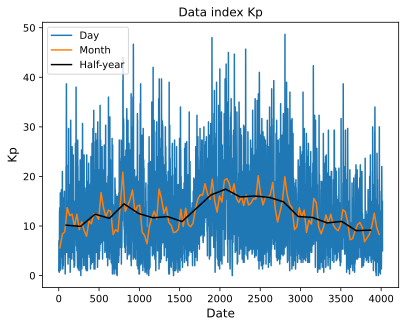

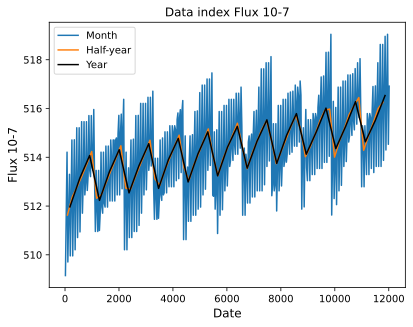

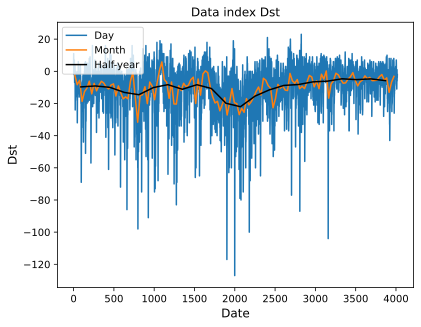

In [4]:
# analyze data

plot_data_index(kp_date, kp_arr, 'Kp')
# plot_data_index(bz_date, bz_arr, 'Imf-Bz')
# plot_data_index(sw_date, sw_arr, 'Solar Wind')
plot_data_index(f107_arr, f107_date, 'Flux 10-7')
plot_data_index(dst_date, dst_mean_arr, 'Dst')

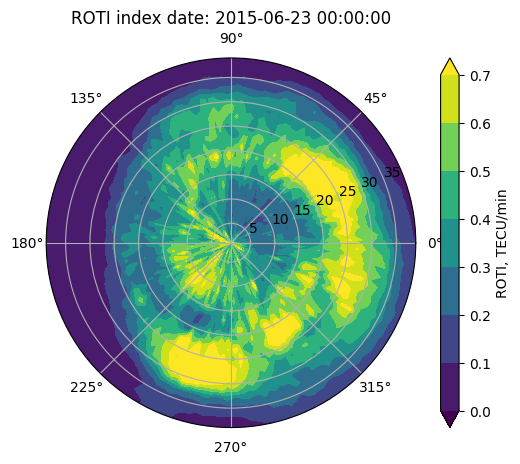

[23, 6, 2015]


In [78]:
# example of ROTI map
# doy = ["020", "021", "022", "023", "024"]
doy = ["174"]
all_maps = []

for day in doy:
    filename = '../data/roti/2010-2020/roti' + day + '0.15f'

    lats = []
    rows = []
    date_map = []

    date, lats, date_map, map = read_roti(filename)

    all_maps.append(map)
    all_map = np.mean(all_maps, axis=0)
    # print("all_map:\n", all_map.shape[1])
    lons = np.linspace(1, 361, all_map.shape[1])
    # lons = np.linspace(1, 361, 180)
    # print("lons:\n", lons)
    plot_data_roti(date, lons, lats, map)

    # date_map.append(map)
    print(date_map)
